In [1]:
import numpy as np
import wormholes as wh
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.tri import Triangulation
from scipy.optimize import curve_fit
from tqdm import tqdm
from itertools import product
import colorcet as cc

In [2]:
# Suppress warnings
# (Many overflows/underflows otherwise, since exp(u,v,φ) appear throughout)
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{amssymb} \\usepackage{amsmath}'

# Massive type IIA on $S^3\times S^3$

A shooting method is used to solve the equations of motion, which take the form (see Mathematica notebook)

$$ \begin{align*}
    & & f' &= F_f(r,f,u,\phi;q_0) \,,\\
    u' &= u_d \,, & \qquad u_d' &= F_{u_d}(r,f,u,u_d,\phi;q_0,\mathfrak{q}) \,,\\
    \phi' &= \phi_d \,, & \phi_d' &= F_{\phi_d}(r,f,u,\phi,\phi_d;q_0,\mathfrak{q}) \,,\\
    & & h' &= \frac{f}{q^3} \,,
\end{align*} $$

with initial conditions at $r=0$,

$$ u_d(0) = \phi_d(0) = h(0) = 0 \,,\qquad f(0)=f_0 \,,\quad u(0)=u_0 \,,\quad \phi(0)=\phi_0 \,, $$

chosen in such a way that the correct AdS boundary conditions are met for $r\to\infty$. For the solution to be smooth at $r=0$ the parameters need to be related through

$$ \begin{align*}
    f_0^{-2} &= 2 - \frac{q_0^2}{2} V(u_0, \phi_0) \,,\\
    \mathfrak{q}^2 &= 4e^{-3u_0+\phi_0/2} q_0^4 (1 + f_0^{-2}) \,.
\end{align*} $$

(Note that we require $f_0^{-2}>0$.) For each fixed $q_0>0$ there is a unique choice for $(u_0,\phi_0)$ which leads to a regular AdS wormhole solution.

### Shooting method: example profiles and parameter space

Picking $(u_0,\phi_0)$ by hand typically results in singular solutions.

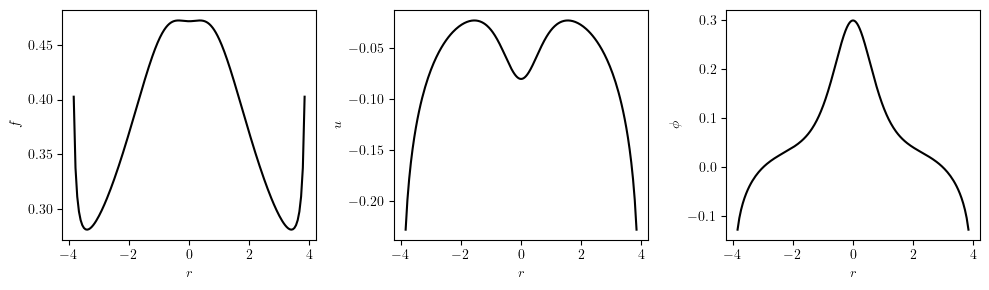

In [5]:
q0, rmax = 1, 5
u0, φ0 = -0.08, 0.3

soln = wh.solve_S3S3(q0, u0, φ0, rmax)
r, f, u, ud, φ, φd, h, charge = wh.symmetrize_S3S3(soln)

fig, axes = plt.subplots(1, 3, figsize=(10,3))

for ax, y, label in zip(axes, [f, u, φ], ['$f$', '$u$', '$\phi$']):
    ax.plot(r, y, 'k')
    ax.set_xlabel('$r$')
    ax.set_ylabel(label)

plt.tight_layout()
plt.show()

Optimal values for $(u_0,\phi_0)$ to match the AdS boundary conditions ($f\sim\frac{1}{r}$ and $u,\phi\to0$ for $r\to\infty$) are found using a shooting method.

S3xS3: (q0, rmax) = (1.000000, 20.000000)...
       success : True
        f_eval : 158
            u0 : -0.0789187231
            φ0 : +0.2943216215
         value : 0


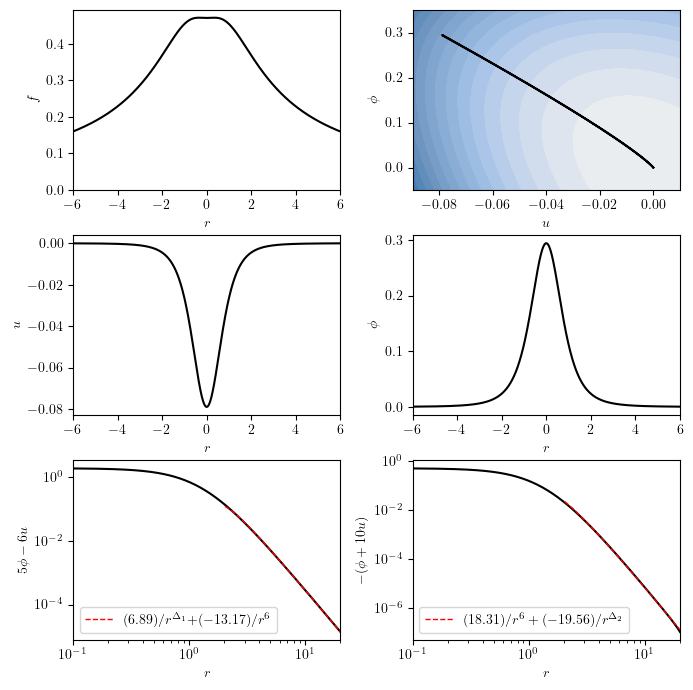

In [6]:
q0, rmax = 1, 20

soln = wh.wormhole_S3S3(q0, rmax, display_summary=True)
r, f, u, ud, φ, φd, h, charge = soln


fig, axes = plt.subplots(3, 2, figsize=(7,7))

q = wh.Q(r, q0)

xdata = [r, u, r, r, r, r]
ydata = [f, φ, u, φ, 5*φ-6*u, -(φ+10*u)]
xlabels = ['$r$', '$u$', '$r$', '$r$', '$r$', '$r$']
ylabels = ['$f$', '$\phi$', '$u$', '$\phi$', '$5\phi-6u$', '$-(\phi+10u)$']

# Plot grid of xy-data
for ax, xx, yy, xlab, ylab in zip(axes.ravel(), xdata, ydata, xlabels, ylabels):
    ax.plot(xx, yy, 'k')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

axes[0,0].set_ylim(0)

for ax in axes.ravel():
    ax.set_xlim(-6*q0, 6*q0)

# Superimpose potential in u-φ plot
u0s = np.linspace(-0.09, 0.01, 40)
φ0s = np.linspace(-0.05, 0.35, 40)
umesh, φmesh = np.meshgrid(u0s, φ0s)
VV = wh.V_S3S3(umesh, φmesh)

axes[0,1].contourf(umesh, φmesh, VV,
                   levels=np.arange(-6, -4.4, 0.1),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], φ0s[0], φ0s[-1])
                  )

axes[0,1].set_xlim(u0s[0], u0s[-1])
axes[0,1].set_ylim(φ0s[0], φ0s[-1])


# Plot expected power-law fall-offs in asymptotic region
rr, light, label_light = wh.fitLightMode_S3S3(r, u, φ, r>2)
axes[2,0].plot(rr, light, '--r', lw=1, label=label_light)

rr, heavy, label_heavy = wh.fitHeavyMode_S3S3(r, u, φ, r>2)
axes[2,1].plot(rr, heavy, '--r', lw=1, label=label_heavy)


for ax in axes[2]:
    ax.set_xlim(0.1*q0, rmax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
# plt.savefig('images/S3S3_profile_example.png', dpi=300)
plt.show()

An overview of the parameter space

In [819]:
q0, rmax = 1, 50

# Make list of (u0,φ0) pairs
u0_list = np.linspace(-0.22, 0.2, 200)
φ0_list = np.linspace(-1.25, 1.25, 100)

u0_list, φ0_list = np.meshgrid(u0_list, φ0_list)
u0_list = u0_list.ravel()
φ0_list = φ0_list.ravel()

# patch near the 'valley' near 5u0+6φ0=0 for higher resolution
x_p, y_p = np.meshgrid(np.linspace(-0.07, -0.03, 50), np.linspace(-1.25, 0.5, 100))
x_p = x_p.ravel()
y_p = y_p.ravel()
x_p += (-0.0867)*y_p

u0_list = np.append(u0_list, x_p)
φ0_list = np.append(φ0_list, y_p)


# Make list of (u0,φ0) pairs for an inset near the optimum
u0_inset = np.linspace(-0.083, -0.073, 150)
φ0_inset = np.linspace(0.24, 0.34, 100)

u0_inset, φ0_inset = np.meshgrid(u0_inset, φ0_inset)
u0_inset = u0_inset.ravel()
φ0_inset = φ0_inset.ravel()

u0s = np.empty([0])
φ0s = np.empty([0])
rdivs = np.empty([0])
udivs = np.empty([0])
φdivs = np.empty([0])

u0s_inset = np.empty([0])
φ0s_inset = np.empty([0])
rdivs_inset = np.empty([0])
udivs_inset = np.empty([0])
φdivs_inset = np.empty([0])

for u0, φ0 in tqdm(zip(u0_list, φ0_list), total=len(u0_list)):
    soln = wh.solve_S3S3(q0, u0, φ0, rmax)

    if len(soln) > 1:
        rdiv = soln[0][-1]
        udiv = soln[2][-1]
        φdiv = soln[4][-1]
        
        u0s = np.append(u0s, u0)
        φ0s = np.append(φ0s, φ0)
        rdivs = np.append(rdivs, rdiv)
        udivs = np.append(udivs, udiv)
        φdivs = np.append(φdivs, φdiv)

for u0, φ0 in tqdm(zip(u0_inset, φ0_inset), total=len(u0_inset)):
    soln = wh.solve_S3S3(q0, u0, φ0, rmax)

    if len(soln) > 1:
        rdiv = soln[0][-1]
        udiv = soln[2][-1]
        φdiv = soln[4][-1]
        
        u0s_inset = np.append(u0s_inset, u0)
        φ0s_inset = np.append(φ0s_inset, φ0)
        rdivs_inset = np.append(rdivs_inset, rdiv)
        udivs_inset = np.append(udivs_inset, udiv)
        φdivs_inset = np.append(φdivs_inset, φdiv)

# get optimal ICs
soln = wh.wormhole_S3S3(q0, rmax, display_summary=True)
u0_best = min(soln[2])
φ0_best = max(soln[4])

100%|██████████| 15000/15000 [04:16<00:00, 58.46it/s]


S3xS3: (q0, rmax) = (1.000000, 50.000000)...
       success : True
        f_eval : 174
            u0 : -0.0789187231
            φ0 : +0.2943216215
         value : 0


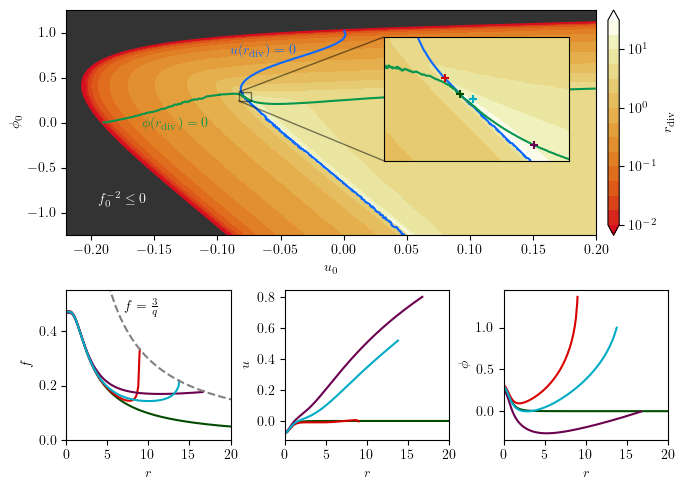

In [823]:
uφ0s = np.array([[u0_best,          φ0_best           ],
                 [u0_best - 0.0008, φ0_best + 0.012245],
                 [u0_best + 0.004,  φ0_best - 0.0415  ],
                 [u0_best + 0.0007, φ0_best - 0.004   ]])
cs = np.asarray(cc.palette['glasbey_dark'])[[19,0,6,3]]

levels = np.geomspace(0.01, np.sqrt(1000), 15)
cmap = cc.cm['CET_L18_r']
norm = colors.LogNorm()

ucolor = cc.palette['glasbey_cool'][0]
φcolor = cc.palette['glasbey_cool'][1]

# make figure with subplots
fig, axes = plt.subplot_mosaic('ppp;fuφ', figsize=(7,5), gridspec_kw={'height_ratios':[3,2]})

# background colors
u0_mesh, φ0_mesh = np.meshgrid(np.linspace(-0.22, 0.2, 100), np.linspace(-1.25, 1.25, 100))
VV = wh.V_S3S3(u0_mesh, φ0_mesh)
axes['p'].set_facecolor('#333')
axes['p'].contourf(u0_mesh, φ0_mesh, VV, levels=[0,4], colors=[cmap.get_under()])

# rdiv contours
im = axes['p'].tricontourf(u0s, φ0s, rdivs, levels=levels, cmap=cmap, norm=norm, extend='both')
cbar = plt.colorbar(im, ax=axes['p'], fraction=0.1, pad=0.02, label=r'$r_\mathrm{div}$')
cbar.ax.set_yticks([0.01, 0.1, 1, 10], labels=['$10^{-2}$', '$10^{-1}$', '$10^0$', '$10^1$'])

# clean boundary
axes['p'].contour(u0_mesh, φ0_mesh, VV, levels=[4], colors=[cmap.get_under()])

# inset rdiv contours
axins = axes['p'].inset_axes([0.6, 0.33, 0.35, 0.55])
axins.tricontourf(u0s_inset, φ0s_inset, rdivs_inset, levels=levels, cmap=cmap, norm=norm, extend='both')
axes['p'].indicate_inset_zoom(axins, edgecolor="black")

# udiv = 0 and φdiv = 0 contours
axes['p'].tricontour(u0s, φ0s, udivs, levels=[0], colors=ucolor)
axes['p'].tricontour(u0s, φ0s, φdivs, levels=[0], colors=φcolor)
axins.tricontour(u0s_inset, φ0s_inset, udivs_inset, levels=[0], colors=ucolor)
axins.tricontour(u0s_inset, φ0s_inset, φdivs_inset, levels=[0], colors=φcolor)

# parameter pairs
for [u0, φ0], c in zip(uφ0s, cs):
    axins.scatter([u0], [φ0], marker='+', c=c, zorder=5)

# labels
axes['p'].text(-0.195, -0.9, '$f_0^{-2}\leq 0$', c='w')
axes['p'].text(-0.09, 0.75, '$u(r_\mathrm{div})=0$', c=ucolor)
axes['p'].text(-0.16, -0.05, '$\phi(r_\mathrm{div})=0$', c=φcolor)

axes['p'].set_xlim(min(u0_list), max(u0_list))
axes['p'].set_ylim(min(φ0_list), max(φ0_list))

axins.set_xlim(min(u0_inset), max(u0_inset))
axins.set_ylim(min(φ0_inset), max(φ0_inset))
axins.set_xticks([])
axins.set_yticks([])

axes['p'].set_xlabel('$u_0$')
axes['p'].set_ylabel('$\phi_0$')


# lower examples
soln = wh.wormhole_S3S3(q0, rmax)
r, f, u, ud, φ, φd, h, charge = soln

for [u0, φ0], c in zip(uφ0s, cs):
    soln = wh.solve_S3S3(q0, u0, φ0, rmax)
    r, f, u, ud, φ, φd, h, charge = wh.symmetrize_S3S3(soln)
    dr = (r[-1] - r[-2])/4
    r = np.append(r, r[-1] + dr)
    f = np.append(f, 3/wh.Q(r[-1], q0))
    u = np.append(u, u[-1] + ud[-1]*dr)
    φ = np.append(φ, φ[-1] + φd[-1]*dr)

    axes['f'].plot(r, f, c=c)
    axes['u'].plot(r, u, c=c)
    axes['φ'].plot(r, φ, c=c)


rr = np.linspace(0, 50, 100)
qq = wh.Q(rr, q0)
axes['f'].plot(rr, 3/qq, '--', c='gray')
axes['f'].text(7, 0.475, r'$f=\tfrac{3}{q}$')

xticks = [0, 5, 10, 15, 20]
axes['f'].set_xticks(xticks)
axes['u'].set_xticks(xticks)
axes['φ'].set_xticks(xticks)

axes['f'].set_xlim(0, 20)
axes['u'].set_xlim(0, 20)
axes['φ'].set_xlim(0, 20)
axes['f'].set_xlabel('$r$')
axes['u'].set_xlabel('$r$')
axes['φ'].set_xlabel('$r$')
axes['f'].set_ylabel('$f$')
axes['u'].set_ylabel('$u$')
axes['φ'].set_ylabel('$\phi$')

axes['f'].set_ylim(0, 0.55)


plt.tight_layout()
plt.subplots_adjust(wspace=0.33)
plt.savefig('images/S3S3_paramspace.png', dpi=500)
plt.show()

### Scalar field ranges

Field ranges for $u$ and $\phi$ remain $\mathcal{O}(1)$ for all $q_0$. Below the field ranges are compared to the ranges of the Giddings-Strominger solution which appears when $u$ and $\phi$ are "approximated" to be massless (via the _ad hoc_ replacement $\mathcal{V}\to -6$).

In [8]:
q0s = np.geomspace(0.0001, 100, 50)

q0s_ml = np.geomspace(min(q0s), max(q0s), 100)
data_ml = np.asarray([wh.massless_approx_S3S3(q0) for q0 in q0s_ml])
u0s_ml, φ0s_ml, charges_ml = data_ml.T

data = []

for q0 in tqdm(q0s):

    rmax = max(10, 10*q0)
    soln = wh.wormhole_S3S3(q0, rmax)
    r, f, u, ud, φ, φd, h, charge = soln

    # u<0 and φ>0 are monotonic
    data.append([min(u), max(φ), charge])

u0s, φ0s, charges = np.asarray(data).T

100%|██████████| 50/50 [11:36<00:00, 13.94s/it]


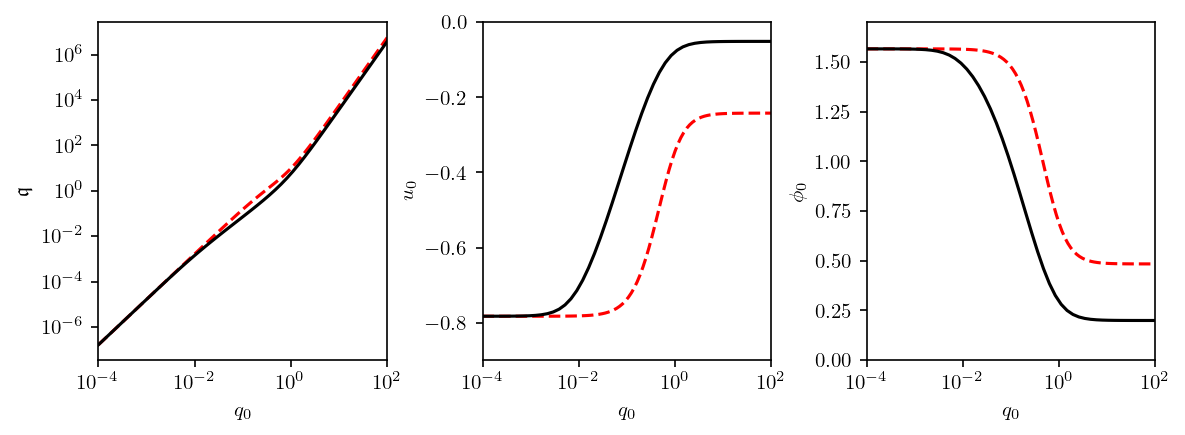

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(8,3), sharex=True)

axes[0].plot(q0s_ml, charges_ml, '--r')
axes[0].plot(q0s, charges, 'k')
axes[0].set_yscale('log')
axes[0].set_ylabel('$\mathfrak{q}$')

axes[1].plot(q0s_ml, u0s_ml, '--r')
axes[1].plot(q0s, u0s, 'k')
axes[1].set_ylabel('$u_0$')
axes[1].set_ylim(-0.9, 0)

axes[2].plot(q0s_ml, φ0s_ml, '--r')
axes[2].plot(q0s, φ0s, 'k')
axes[2].set_ylabel('$\phi_0$')
axes[2].set_ylim(0, 1.7)

plt.xlim(min(q0s), max(q0s))
plt.xscale('log')
for ax in axes:
    ax.set_xlabel('$q_0$')

plt.tight_layout()
plt.subplots_adjust(wspace=0.33)
# plt.savefig('images/S3S3_ranges.png', dpi=300)
plt.show()

### Flat-space limit

The flat-space limit is $\ell\to\infty$ with $a_0=\ell q_0$ held fixed. As $q_0\ll1$ there are three distinct regions: (i) $r\lesssim q_0$ is within the wormhole where $u,\phi,f$ are approximately constant, (ii) $q_0\lesssim r\lesssim 1$ is 'outside' the wormhole but still below the AdS scale where $u,\phi$ decay as $1/r^2$ (like massless scalars in flat space) and $f\approx 1$, and (iii) $r\gtrsim 1$ is above the AdS scale where the light/heavy eigenstates decay towards the boundary. The appropriately rescaled radial coordinate and flux to realize the flat-space limit are $\ell r$ and $\ell^2\mathfrak{q}$. Notice that the metric only converges point-wise (i.e. not uniformly) since $f\to1$ in the flat-space limit $\ell\to\infty$, while $f\xrightarrow{\ell r\gtrsim\ell}\frac{1}{r}$ for any finite $\ell$.

100%|██████████| 5/5 [01:10<00:00, 14.03s/it]


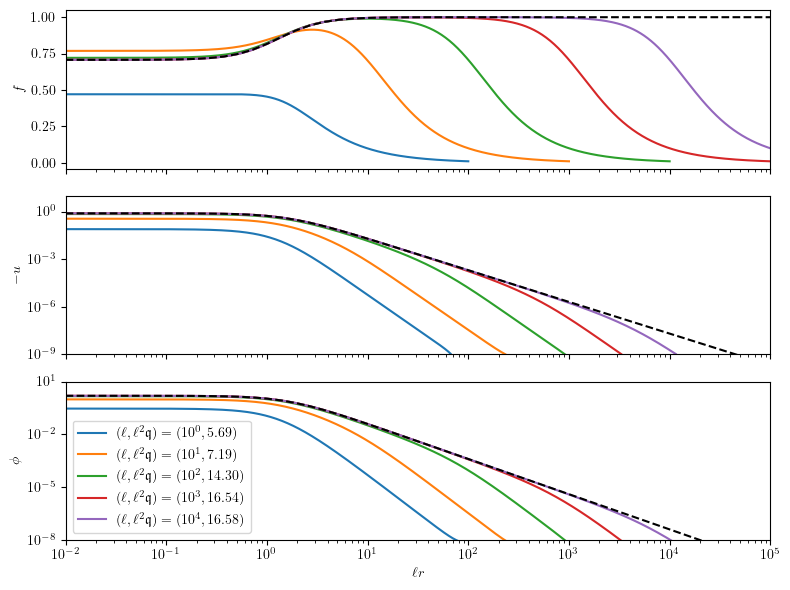

In [37]:
a0 = 1
powers = np.arange(0, 5, 1)

fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

for power in tqdm(powers):
    l = 10**power
    q0 = a0 / l
    
    rmax = min(100, 10**5 / l)
    soln = wh.wormhole_S3S3(q0, rmax)
    r, f, u, ud, φ, φd, h, charge = soln

    axes[0].plot(l*r, f)

    cut = np.where((r > 0) * (-u < 10**-9))[0][0]
    axes[1].plot(l*r[:cut], -u[:cut])

    label = '$(\ell,\ell^2\mathfrak q)=(10^{},{:.2f})$'.format(power, charge*l**2)
    axes[2].plot(l*r, φ, label=label)


# Plot flat-space profiles
rr = np.geomspace(10**-2, 10**5)
a = wh.Q(rr, a0)
ad = wh.Qd(rr, a0)

ff = ad / np.sqrt(1 - (a0/a)**4)
φφ = np.log(np.cos(np.sqrt(3)/2 * np.arctan(np.sqrt((a/a0)**4 - 1))) / np.cos(np.sqrt(3)*np.pi/4))

axes[0].plot(rr, ff, '--k')
axes[1].plot(rr, 0.5*φφ, '--k')
axes[2].plot(rr, φφ, '--k')


plt.xlim(10**-2, 10**5)
plt.xscale('log')
plt.xlabel('$\ell r$')

axes[0].set_ylabel('$f$')

axes[1].set_ylim(10**-9, 10)
axes[1].set_yscale('log')
axes[1].set_ylabel('$-u$')

axes[2].set_ylim(10**-8, 10)
axes[2].set_yscale('log')
axes[2].set_ylabel('$\phi$')
axes[2].legend()

plt.tight_layout()
# plt.savefig('images/S3S3_flat_limit.png', dpi=300)
plt.show()

# Type IIB on $T^{1,1}$

### Example profiles & shooting method

Picking $(u_0,v_0)$ by hand typically results in singular solutions.

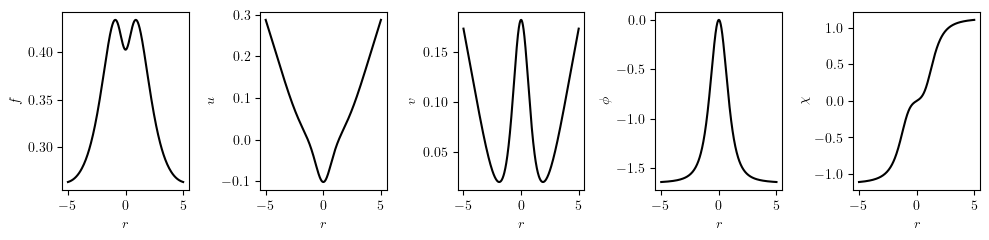

In [5]:
q0, rmax = 1, 5
u0, v0 = -0.102, 0.182
χ1 = 0.1

soln = wh.solve_T11(q0, u0, v0, 0, χ1, rmax)
r, f, u, ud, v, vd, φ, φd, χ, χd, h, charge2 = wh.symmetrize_T11(soln)

fig, axes = plt.subplots(1, 5, figsize=(10,2.5))

for ax, y, label in zip(axes, [f, u, v, φ, χ], ['$f$', '$u$', '$v$', '$\phi$', '$\chi$']):
    ax.plot(r, y, 'k')
    ax.set_xlabel('$r$')
    ax.set_ylabel(label)

plt.tight_layout()
plt.show()

Optimal values for $(u_0,v_0)$ to match the AdS boundary conditions ($f\sim\frac{1}{r}$ and $u,v,\phi',\chi'\to0$ for $r\to\infty$) are found using a shooting method.

T11: (q0, χ1, rmax) = (1.000000, 0.100000, 10.000000)...
       success : True
        f_eval : 249
            u0 : -0.1028891470
            v0 : +0.1823857261
         value : 0


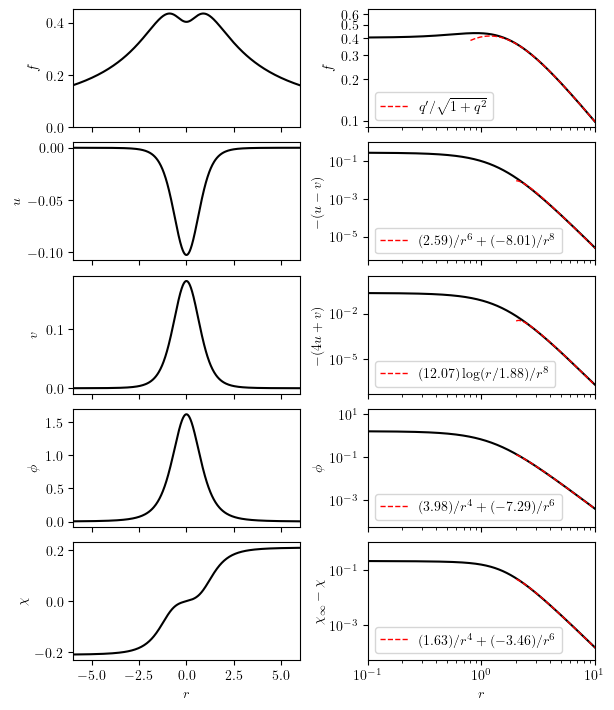

In [20]:
q0 = 1
rmax = 10
χ1 = 0.1

soln, value = wh.wormhole_T11(q0, χ1, rmax, display_summary=True)
r, f, u, ud, v, vd, φ, φd, χ, χd, h, charge2 = soln

# Estimate χinf by fitting χ to a function of the form A + B/r^4 + C/r^6
mask = (r > rmax/1.5)
popt, pcov = curve_fit(wh.myMassless_T11, r[mask], χ[mask])
χinf = popt[0]


fig, axes = plt.subplots(5, 2, figsize=(6,7), sharex='col')

ydata = [f, f, u, -(u-v), v, -(4*u+v), φ, φ, χ, χinf-χ]
ylabels = ['$f$', '$f$', '$u$', '$-(u-v)$', '$v$', '$-(4u+v)$', '$\phi$', '$\phi$', '$\chi$', '$\chi_\infty - \chi$']

# Plot grid of xy-data
for ax, yy, ylab in zip(axes.ravel(), ydata, ylabels):
    ax.plot(r, yy, 'k')
    ax.set_ylabel(ylab)

axes[4,0].set_xlabel('$r$')
axes[4,1].set_xlabel('$r$')


# Plot expected power-law fall-offs in asymptotic region
rr = np.linspace(0.8, rmax, 1000)
q = wh.Q(rr, q0)
qd = wh.Qd(rr, q0)
axes[0,1].plot(rr, qd/np.sqrt(1+q**2), '--r', lw=1, label=r"$q'/\sqrt{1+q^2}$")

rr, light, label_light = wh.fitLightMode_T11(r, u, v, r>2)
axes[1,1].plot(rr, light, '--r', lw=1, label=label_light)

rr, heavy, label_heavy = wh.fitHeavyMode_T11(r, u, v, r>2)
axes[2,1].plot(rr, heavy, '--r', lw=1, label=label_heavy)

rr, φfit, label_φ = wh.fitMassless_T11(r, φ, r>2)
axes[3,1].plot(rr, φfit, '--r', lw=1, label=label_φ)

rr, χfit, label_χ = wh.fitMassless_T11(r, χinf-χ, r>2)
axes[4,1].plot(rr, χfit, '--r', lw=1, label=label_χ)

for ax in axes[:,1]:
    ax.set_yscale('log')
    ax.legend(loc='lower left')

axes[0,0].set_ylim(0)
axes[0,1].set_ylim(0.09, 0.65)
yticks = np.arange(0.1, 0.7, 0.1)
axes[0,1].set_yticks(yticks, labels=[r'${:.1f}$'.format(y) for y in yticks])
axes[1,1].set_ylim(10**-6.25, 1)
axes[2,1].set_ylim(10**-7.25, 10**0.5)
axes[3,1].set_ylim(10**-4.25, 10**1.25)
axes[4,1].set_ylim(10**-4.25, 1)

axes[3,0].set_xlim(-6*q0, 6*q0)
axes[3,1].set_xlim(0.1*q0, rmax)
axes[3,1].set_xscale('log')


plt.tight_layout()
plt.subplots_adjust(left=0.11, right=0.98, top=0.99, bottom=0.06, wspace=0.3, hspace=0.13)
# plt.savefig('images/T11_profiles_ex1.png', dpi=300)
plt.show()

### Scalar field ranges & BPS bounds

First collect/load data:

In [7]:
# data_T11 = np.empty([13, 0])
data_T11 = np.load('T11_data.npy')

In [8]:
# Polynomial parameters which estimate the largest χ1 as a function of log(q0) on 0.01 < q0 < 10
# Evaluate using np.polyval(χ1max_fit_params, np.log(q0))
χ1max_fit_params = [ 8.36517999e-06,  1.11900249e-04,  3.82278703e-04, -8.83490112e-04,
                    -6.79118040e-03, -1.32155348e-03,  4.40613220e-02,  3.02091352e-02,
                    -1.61250423e-01, -1.50605858e-01,  5.43067718e-01]

In [9]:
def run(q0, χ1, rmax, xatol=10**-10, display_summary=False, display_progress=False):

    soln, value = wh.wormhole_T11(q0, χ1, rmax,
                                  xatol=xatol,
                                  display_summary=display_summary,
                                  display_progress=display_progress
                                 )

    if soln is None or value > 10**-4:
        return None, value
        
    r, f, u, ud, v, vd, φ, φd, χ, χd, h, charge2 = soln

    # Get field ranges
    u0 = min(u)
    v0 = max(v)
    φ0 = max(φ)

    # Get Ricci scalars (5D and 10D)
    ric5 = min(wh.ricci_5D(q0, soln))
    ric10 = min(wh.ricci_10D(q0, soln))

    # Estimate φ4, χ4 and χinf
    mask = (r > rmax/1.5)
    
    popt, pcov = curve_fit(wh.myMasslessDeriv_T11, r[mask], r[mask]**5 * φd[mask])
    φ4 = popt[0]

    popt, pcov = curve_fit(wh.myMasslessDeriv_T11, r[mask], r[mask]**5 * (φd[mask] + χd[mask]))
    φχ4 = popt[0]
    
    if χ1 == 0:
        χinf, χ4 = 0, 0
    else:
        popt, pcov = curve_fit(wh.myMassless_T11, r[mask], χ[mask])
        χinf = popt[0]

        popt, pcov = curve_fit(wh.myMasslessDeriv_T11, r[mask], r[mask]**5 * χd[mask])
        χ4 = popt[0]

    return [q0, χ1, rmax, u0, v0, φ0, φ4, χ4, φχ4, χinf, charge, ric5, ric10], value

In [89]:
# n_q0 = 50

# q0_list = 10**(3*np.random.rand(n_q0) - 2)
# q0_list = np.geomspace(0.01, 10, 10)
q0_list = [0.012]

for q0 in q0_list:

    # Data for fixed q0
    data_q0 = np.empty([13, 0])

    rmax = max(10, 10*q0)

    # Estimate χ1max for 0.01 < q0 < 10
    χ1max_est = np.polyval(χ1max_fit_params, np.log(q0))

    # Do scan over evenly spaced χ1
    χ1_list = χ1max_est * np.linspace(0, 1, 10, endpoint=False)
    # χ1_list = [(0.25*np.random.rand()+0.2)*χ1max_est]

    for χ1 in χ1_list:

        print('q0 = {:.4f}    χ1 = {:.8f}    χ1max_est = {:.8f}'.format(q0, χ1, χ1max_est), end='')
        run_data, value = run(q0, χ1, rmax, xatol=10**-16)

        if run_data is None:
            print('    Failed to converge')
        else:
            print('    χ1inf = {:.8f}    val_final = {:.4g}'.format(run_data[9], value))
            data_q0 = np.append(data_q0, np.array([run_data]).T, axis=1)


    # Now pick χ1 approaching χ1max geometrically
    for _ in range(20):

        # Get current estimate of χ1max by fitting the χ1(χ1inf) data and evaluating χ1(1)
        fit = np.polyfit(data_q0[9], data_q0[1], 3)
        χ1max_est = np.polyval(fit, 1)

        # Move part-way to χ1max_est
        χ1 = (2*χ1 + χ1max_est) / 3

        print('q0 = {:.4f}    χ1 = {:.8f}    χ1max_est = {:.8f}'.format(q0, χ1, χ1max_est), end='')
        run_data, value = run(q0, χ1, rmax)

        if run_data is None:
            print('    Failed to converge')
            break
        elif run_data[9] < data_q0[9, -1]:
            print('    Lower χ1inf')
            break
        else:
            print('    χ1inf = {:.8f}    val_final = {:.4g}'.format(run_data[9], value))
            data_q0 = np.append(data_q0, np.array([run_data]).T, axis=1)

    data_T11 = np.append(data_T11, data_q0, axis=1)

q0 = 0.0120    χ1 = 0.00000000    χ1max_est = 0.42039933    χ1inf = 0.00000000    val_final = 0
q0 = 0.0120    χ1 = 0.04203993    χ1max_est = 0.42039933    χ1inf = 0.09949695    val_final = 1.998e-15
q0 = 0.0120    χ1 = 0.08407987    χ1max_est = 0.42039933    χ1inf = 0.19899330    val_final = 4.441e-16
q0 = 0.0120    χ1 = 0.12611980    χ1max_est = 0.42039933    χ1inf = 0.29848850    val_final = 1.132e-14
q0 = 0.0120    χ1 = 0.16815973    χ1max_est = 0.42039933    χ1inf = 0.39798197    val_final = 4.441e-16
q0 = 0.0120    χ1 = 0.21019967    χ1max_est = 0.42039933    χ1inf = 0.49747315    val_final = 1.554e-15
q0 = 0.0120    χ1 = 0.25223960    χ1max_est = 0.42039933    χ1inf = 0.59696146    val_final = 9.77e-15
q0 = 0.0120    χ1 = 0.29427953    χ1max_est = 0.42039933    χ1inf = 0.69644633    val_final = 5.107e-15
q0 = 0.0120    χ1 = 0.33631946    χ1max_est = 0.42039933    χ1inf = 0.79592719    val_final = 8.882e-16
q0 = 0.0120    χ1 = 0.37835940    χ1max_est = 0.42039933    χ1inf = 0.895

In [10]:
data_T11 = data_T11[:, data_T11[9] < 1]
np.save('T11_data.npy', data_T11)

q0s, χ1s, rmaxs, u0s, v0s, φ0s, φ4s, χ4s, φχ4s, χinfs, charge2s, ric5s, ric10s = data_T11

bps = 4*(φ4s + χ4s)/charge2s - (1 - χinfs)

For $\chi=0$ the values of $u_0$, $v_0$, $\phi_0$ and the flux can be compared with the two Giddings-Strominger "approximations".

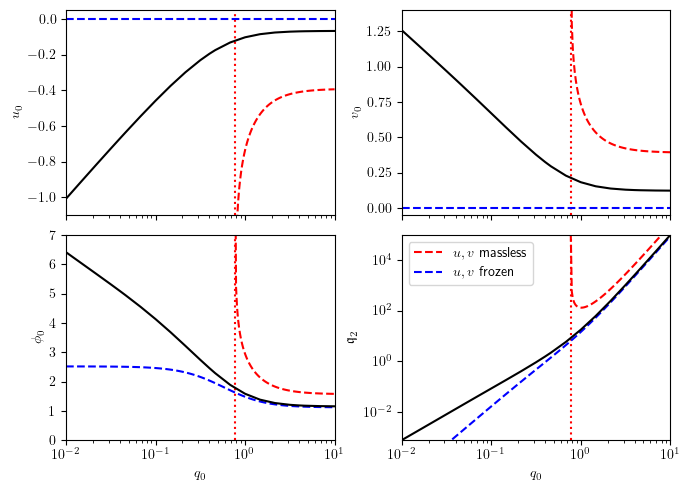

In [11]:
mask = np.where(χinfs == 0)[0]
mask = mask[np.argsort(q0s[mask])]

q0s_ml = np.geomspace(0.7728, max(q0s[mask]), 100)
data_ml = np.asarray([wh.massless_approx_T11(q0) for q0 in q0s_ml])
u0_ml, v0_ml, φ0_ml, charge2_ml = data_ml.T

q0s_fr = np.geomspace(min(q0s[mask]), max(q0s[mask]), 100)
data_fr = np.asarray([wh.frozen_approx_T11(q0) for q0 in q0s_fr])
u0_fr, v0_fr, φ0_fr, charge2_fr = data_fr.T


fig, axes = plt.subplots(2, 2, figsize=(7,5), sharex=True)

axes[0,0].plot(q0s_ml, u0_ml, '--r')
axes[0,0].plot(q0s_fr, u0_fr, '--b')
axes[0,0].plot(q0s[mask], u0s[mask], 'k')

axes[0,1].plot(q0s_ml, v0_ml, '--r')
axes[0,1].plot(q0s_fr, v0_fr, '--b')
axes[0,1].plot(q0s[mask], v0s[mask], 'k')

axes[1,0].plot(q0s_ml, φ0_ml, '--r')
axes[1,0].plot(q0s_fr, φ0_fr, '--b')
axes[1,0].plot(q0s[mask], φ0s[mask], 'k')

axes[1,1].plot(q0s_ml, charge2_ml, '--r', label='$u,v$ massless')
axes[1,1].plot(q0s_fr, charge2_fr, '--b', label='$u,v$ frozen')
axes[1,1].plot(q0s[mask], charge2s[mask], 'k')

for ax, ylab in zip(axes.ravel(), ['$u_0$', '$v_0$', '$\phi_0$', '$\mathfrak{q}_2$']):
    ax.axvline(q0s_ml[0], ls=':', c='r', zorder=0)
    ax.set_ylabel(ylab)

plt.xlim(min(q0s[mask]), max(q0s[mask]))
plt.xscale('log')
axes[1,0].set_xlabel('$q_0$')
axes[1,1].set_xlabel('$q_0$')

axes[0,0].set_ylim(-1.1, 0.05)
axes[0,1].set_ylim(-0.05, 1.4)
axes[1,0].set_ylim(0, 7)
axes[1,1].set_ylim(min(charge2s[mask]), max(charge2s[mask]))
axes[1,1].set_yscale('log')

axes[1,1].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
# plt.savefig('images/T11_ranges_chi=0.png', dpi=300)
plt.show()

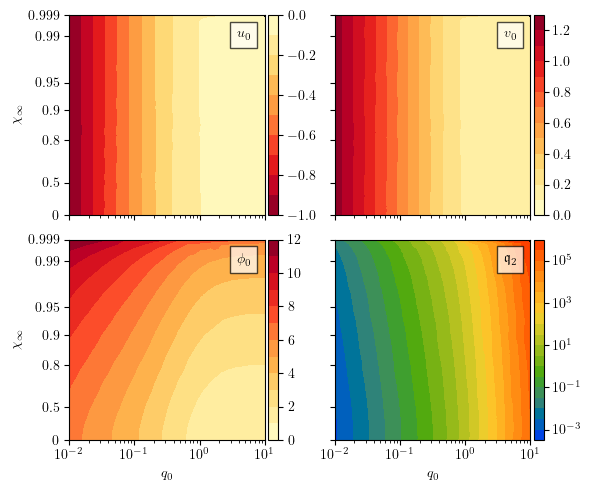

In [35]:
# Custom nonlinear rescaling of vertical axis
x0 = 1.015
def myTransform(x):
    return -x0*np.log(1-x/x0)
def myTransform_inverse(x):
    return x0*(1 - np.exp(-x/x0))

# Perform triangulation on transformed data
tri = Triangulation(np.log(q0s), myTransform(χinfs))
tri.x = np.exp(tri.x)
tri.y = myTransform_inverse(tri.y)


fig, axes = plt.subplots(2, 2, figsize=(6,5), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.set_facecolor('black')

pad = 0.015
fraction = 0.05

levels = np.arange(-1, 0.01, 0.1)
im = axes[0,0].tricontourf(tri, u0s, levels=levels, cmap='YlOrRd_r')
plt.colorbar(im, ax=axes[0,0], pad=pad, fraction=fraction, ticks=np.arange(-1, 0.01, 0.2))

levels = np.arange(0, 1.31, 0.1)
im = axes[0,1].tricontourf(tri, v0s, levels=levels, cmap='YlOrRd')
plt.colorbar(im, ax=axes[0,1], pad=pad, fraction=fraction, ticks=np.arange(0, 1.31, 0.2))

levels = np.arange(0, 12.01, 1)
im = axes[1,0].tricontourf(tri, φ0s, levels=levels, cmap='YlOrRd')
plt.colorbar(im, ax=axes[1,0], pad=pad, fraction=fraction, ticks=np.arange(0, 12.01, 2))

im = axes[1,1].tricontourf(tri, charge2s, levels=10**np.arange(-3.5, 6.5, 0.5),
                           cmap=cc.cm['CET_R2'], norm=colors.LogNorm())
exponents = np.arange(-3, 6.01, 2)
ticks = 10**exponents
cbar = plt.colorbar(im, ax=axes[1,1], pad=pad, fraction=fraction, ticks=ticks)
cbar.ax.set_yticklabels(['$10^{' + '{:.0f}'.format(ii) + '}$' for ii in exponents])

labels = ['$u_0$', '$v_0$', '$\phi_0$', '$\mathfrak{q}_2$']
for ax, label in zip(axes.ravel(), labels):
    ax.text(6, 0.989, label, ha='right',
            bbox={'boxstyle': 'square', 'alpha': 0.7, 'facecolor': 'w', 'edgecolor': 'k', 'pad': 0.5})

for ax in axes[:, 0]:
    ax.set_ylabel('$\chi_\infty$')

plt.xscale('log')
axes[1,0].set_xlabel('$q_0$')
axes[1,1].set_xlabel('$q_0$')

plt.yscale('function', functions=(myTransform, myTransform_inverse))
plt.ylim(0, 0.999)
yticks = [0, 0.5, 0.8, 0.9, 0.95, 0.99, 0.999]
plt.yticks(yticks, labels=['${}$'.format(yt) for yt in yticks])


plt.tight_layout()
plt.subplots_adjust(hspace=0.12)
# plt.savefig('images/T11_ranges.png', dpi=300)
plt.show()

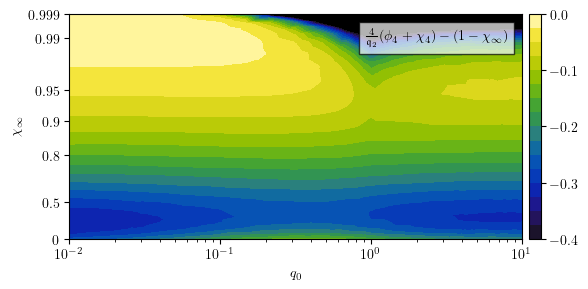

In [36]:
fig, ax = plt.subplots(1,1, figsize=(6,3))

ax.set_facecolor('black')

levels = np.arange(0, -0.41, -0.025)[::-1]
im = ax.tricontourf(tri, bps, levels=levels, cmap=cc.cm['CET_L16'])
plt.colorbar(im, ax=ax, pad=pad, fraction=fraction, ticks=np.arange(0, -0.41, -0.1))

label = '$\\frac{4}{\mathfrak{q}_2}(\phi_4+\chi_4) - (1-\chi_\infty)$'
ax.text(8, 0.989, label, ha='right',
            bbox={'boxstyle': 'square', 'alpha': 0.7, 'facecolor': 'w', 'edgecolor': 'k', 'pad': 0.5})

plt.xscale('log')
ax.set_xlabel('$q_0$')
ax.set_ylabel('$\chi_\infty$')

plt.yscale('function', functions=(myTransform, myTransform_inverse))
plt.ylim(0, 0.999)
yticks = [0, 0.5, 0.8, 0.9, 0.95, 0.99, 0.999]
plt.yticks(yticks, labels=['${}$'.format(yt) for yt in yticks])


plt.tight_layout()
# plt.savefig('images/T11_BPS.png', dpi=300)
plt.show()